# Boosting für Machine Learning

Wir beschäftigen uns mit den grundlegenden Varianten des sogenannten _Boostings_.
Dabei legen wir unser Augenmerk auf Boosting für die Klassifikation.
Insbesondere klassifizieren wir Reden von deutschen Politikern, d.h. aus einem gegebenen Redetext ermitteln wir wer diese Rede hielt.
(Diese Problemstellung war bereits Thema im den Übungen des [codecentric.AI](https://www.codecentric.de/kuenstliche-intelligenz/) Bootcamp zum Thema [Natural Language Processing](https://www.youtube.com/watch?v=GmLsb-o7hvM).)

_Angenommen für unser Problem steht ein schlechter Klassifikator L zur Verfügung._
_Wie können wir aus K einen guten Klassifikator L erzeugen?_

Unter einem schlechten Klassifikator verstehen wir einen Klassifikator mit schlechter Vorhersagekraft, d.h. er macht viele Fehler.
(Die Theorie erlaubt sogar so viele Fehler, dass die Kraft nur wenig besser als zufälliges Raten ist!)
Der neue Klassifikator L wird keine abgewandelte Form von K sein, sondern L besteht aus mehreren geschickt kombinierten Instanzen von K.
Daher bezeichnet man L auch als _Ensemble_.

Ensembles lassen sich für unterschiedliche zugrunde liegende Typen von Klassifikatoren erstellen.
Hier beschränken wir uns auf den Fall, dass K ein einfacher [Entscheidungsbaum-Klassifikator](https://en.wikipedia.org/wiki/Decision_tree_learning) ist.
Die Klassifikation des Ensembles L ergibt sich aus den individuellen Klassifikationen der beteiligten Entscheidungsbäume.

## Daten laden

Werfen wir zuerst einen Blick auf die Daten.
Wir verwenden den von Barbaresi und Adrien bereitgestellten Datensatz [1], der unter der URL [2] verfügbar ist.

[1] Barbaresi, Adrien (2018). "A corpus of German political speeches from the 21st century", Proceedings of the Eleventh International Conference on Language Resources and Evaluation (LREC 2018), European Language Resources Association (ELRA), pp. 792–797.

[2] http://purl.org/corpus/german-speeches

Hier ein Einblick in wenige zufällig ausgewählte Reden.

In [1]:
%run define_load_data_functions.ipynb

df = load_data()

display(df.sample(n=len(df)).head())

,person,speech
1973,Angela Merkel,Liebe Kolleginnen und Kollegen aus dem Deutsch...
616,Gerhard Schröder,Zunächst bedanke ich mich sehr herzlich im Nam...
2552,Monika Grütters,"In ihrer Rede sagte Monika Grütters ""Dass die ..."
2225,Angela Merkel,Bei drängenden politischen Fragen ist es das e...
2309,Monika Grütters,"""Wir brauchen experimentierfreudige Künstler u..."


Im Datensatz ist Angela Merkel mit der weitaus stärksten Anzahl von Reden vertreten.

In [2]:
speech_counts = df.person.value_counts()

display(speech_counts)

Angela Merkel              1125
Gerhard Schröder            418
Bernd Neumann               323
Monika Grütters             245
Christina Weiss             203
k.A.                         88
Michael Naumann              61
Julian Nida-Rümelin          47
Thomas de Maizière           43
Hans Martin Bury             42
Joschka Fischer              31
Rolf Schwanitz               24
Frank-Walter Steinmeier       7
Andere                        4
Jullian Nida-Rümelin          1
Name: person, dtype: int64

Wir beschränken uns auf die binäre Klassifikation, d.h. wir unterscheiden nur zwischen zwei Klassen von Personen.
Um auf ausgewogenen Daten zu arbeiten wählen wir die Klassen _Angela Merkel_ und _Nicht Angela Merkel (Andere)_.
Dazu vernachlässigen wir zuerst alle Personen, die mit nur wenigen Reden vertreten sind.

In [3]:
MIN_NUM_SPEECHES = 100
belowThreshold = lambda name: speech_counts[name] < MIN_NUM_SPEECHES

dropped = filter(belowThreshold, speech_counts.index.tolist())
df.drop(df[df.person.isin(dropped)].index, inplace=True)

display(df.person.value_counts())

Angela Merkel       1125
Gerhard Schröder     418
Bernd Neumann        323
Monika Grütters      245
Christina Weiss      203
Name: person, dtype: int64

Dann fassen wir alle verbleibenden Personen zur Klasse _Andere_ zusammen.

In [4]:
df.loc[df['person'] != "Angela Merkel", ['person']] = 'Andere'

display(df.person.value_counts())

Andere           1189
Angela Merkel    1125
Name: person, dtype: int64

## Daten vorverarbeiten

Es folgt eine Vorverarbeitung der Reden mit Hilfe der NLP-Bibliothek [spaCy](https://spacy.io/).
In diesem Schritt zerlegen wir jede Rede in ihre (durch Whitespace getrennten) Bestandteile, die sogenannten _Tokens_.
In dem Zuge entfernen wir Tokens mit geringer Information, wie z.B. Interpunktion und Stoppwörter ("und", "der", "die", "das", ...).
Außerdem überführen wir jedes Token in seine Grundform, das sogenannte _Lemma_ (z.B. "angekündigt" -> "ankündigen").

In [5]:
%run init_spacy.ipynb
%run define_preprocessing.ipynb

df = load_cached_or_preprocess(df.speech)

display(df.head())

,person,speech,tokens,lemmata
0,Andere,"es ist angekündigt worden, man sollte im Beruf...","[angekündigt, Beruf, Schauspieler, Politiker, ...","[ankündigen, berufen, schauspielern, Politiker..."
2,Andere,Frage (Peter Hahne): Bevor wir uns über den Au...,"[Frage, Peter, Hahne, Bevor, Aufbau, Ost, Arbe...","[Frage, Peter, Hahn, bevor, Aufbau, Ost, Arbei..."
3,Andere,"Einen Satz von Ihnen, Herr Dr. Bernotat, habe ...","[Satz, Herr, Dr., Bernotat, aufgeschrieben, Ar...","[Satz, Herr, Dr., Bernotat, aufschreiben, Argu..."
4,Andere,diese Jahresversammlung der Hochschulrektorenk...,"[Jahresversammlung, Hochschulrektorenkonferenz...","[Jahresversammlung, Hochschulrektorenkonferenz..."
5,Andere,"ich habe nie einen Hehl daraus gemacht, dass i...","[Hehl, Stadt, komme, Amtszeit, Gast, gefühlt, ...","[Hehl, Stadt, kommen, Amtszeit, gasen, fühlen,..."


Für jede Rede R überführen wir nun die Folge von Lemmata von R in das "Histogramm" der Lemmahäufigkeiten von R.
Bemerke, dass wir in diesem Schritt die der Reihenfolge Worte vergessen.
(Man nennt solch eine vereinfachte Darstellung einer Wortfolge auch _bag of words_, um das Abhandensein von zeitlicher Information zu betonen.)

Schauen wir uns ein paar Lemmata und die gewonnene Darstellung einer Rede im Detail an.
(Einige Lemmata sind nicht "perfekt".
Sie enthalten etwa Bindestriche oder liegen in gebeugter Form vor.
Hier wird die Unschäfe der Sprache und ihrer Verarbeitung deutlich.
Beispielsweise geschieht Lemmatisierung in spaCy nicht durch Anwendung eines Regelwerks, sondern durch neuronale Netze, die natürlich nicht in allen Fällen korrekte Ergebnisse erzielen.)

In [6]:
%run define_feature_computation.ipynb

(lemmata, lemma_index) = compute_index(df["lemmata"])
df["lemma_counts"] = count(df["lemmata"], lemma_index)

display(lemmata[:10])
display(df.iloc[0])

['gebend',
 'Ausgleichsflächen',
 'Berührende',
 'Integrationsgipfelprozess',
 'syrisch',
 'Versuchsanstalt',
 'Misserfolgen',
 'Schwund',
 'Herrren',
 'Stimmgewalt']

person                                                     Andere
speech          es ist angekündigt worden, man sollte im Beruf...
tokens          [angekündigt, Beruf, Schauspieler, Politiker, ...
lemmata         [ankündigen, berufen, schauspielern, Politiker...
lemma_counts    {26544: 1, 31276: 1, 80792: 1, 96767: 1, 28615...
Name: 0, dtype: object

## Training

Bis hier haben wir aus den Reden die für das Modell-Training benötigten statistischen Informationen extrahiert.
Zum Start des Trainings fehlt nur noch die Konvertierung diese Informationen in das benötigte Eingabedatenformat.

Zum Training nutzen wir die ML-Bibliothek [scikit-learn](https://scikit-learn.org/stable/).
Die eingegebenen Trainingdaten bestehen aus einer Sammlung von sogenannten _Labels_ (eins pro Rede) und sogenannten _Featurevektoren_ (ebenfalls einer pro Rede).
In unserem Fall gibt das Label einer Rede R an, welche Person die Rede R hielt ("Angela Merkel" oder "Andere").
Der Feature-Vektor von R kodiert das Histogramm der Lemmahäufigkeiten von R (haben wir oben bereits berechnet).

Für die Eingabe in die Algorithmen von scikit-learn werden alle Labels in einen Vektor zusammengefasst.
Analog werden alle Featurevektoren zu einer Matrix zusammengefasst.
Dafür müssen natürlich alle Featurevektoren die gleiche Länge haben, was wir mit Hilfe der Funktion `dict_to_sparse` erledigen.
(Insbesondere gibt diese Funktion eine sogenannte _dünn besetzte Matrix_ aus, in der Einträge mit Wert Null nicht explizit gespeichert werden.
Warum?
In einer Rede erscheinen bei Weitem nicht alle möglichen Lemmata, folglich enthält jeder Featurevektor viele Nullen.
Wir sparen also viel Speicherplatz.)

In [7]:
%run define_conversion_functions.ipynb

feature_vectors = dict_to_sparse(df["lemma_counts"], len(lemma_index))
categories = df["person"].astype("category")
labels = categories.cat.codes

Möge das Training beginnen.
Erinnere, dass wir Ensembles von schwachen Klassifizierern erstellen möchten.
Als schwachen Klassifizierer wählen wir einen sogenannten _Decision Stump_, d.h. einen Entscheidungsbaum der Tiefe 1.

In [9]:
def make_decision_stump():
    return DecisionTreeClassifier(max_depth=1)

0.7755395683453238

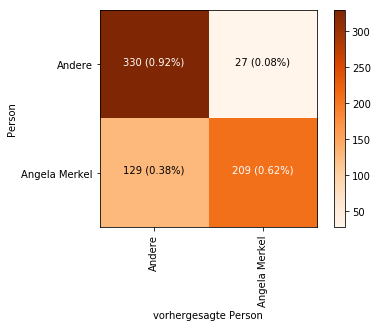

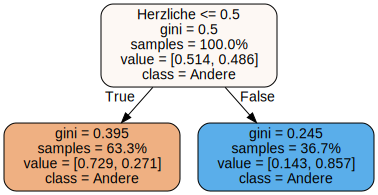

In [16]:
%run define_plot_functions.ipynb
%run define_train_functions.ipynb

from sklearn.tree import DecisionTreeClassifier

# proportion of test data
TRAIN_TEST_RATIO = 0.3

classifier = make_decision_stump()

(accuracy, confusion) = train_and_test_with(classifier,
                                            feature_vectors,
                                            labels,
                                            test_size=TRAIN_TEST_RATIO)

display(accuracy)
display_confusion_matrix(confusion, classes = categories.unique())
display_decision_tree(classifier)

## Boosting

In [ ]:
from sklearn.ensemble import BaggingClassifier

BOOST_FACTOR = 20
ALL_CORES = -1

base = make_decision_stump()
classifier = BaggingClassifier(base_estimator=base,
                               n_estimators=BOOST_FACTOR,
                               n_jobs=ALL_CORES)

(accuracy, confusion) = train_and_test_with(classifier,
                                            feature_vectors,
                                            labels,
                                            test_size=TRAIN_TEST_RATIO)

display(accuracy)
plot_confusion_matrix(confusion, classes=categories.unique())
for tree in classifier:
    display_decision_tree(tree)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

base = make_decision_stump()
classifier = AdaBoostClassifier(base_estimator=base,
                                n_estimators=BOOST_FACTOR)

(accuracy, confusion) = train_and_test_with(classifier,
                                            feature_vectors,
                                            labels,
                                            test_size=TRAIN_TEST_RATIO)

display(accuracy)
plot_confusion_matrix(confusion, classes=categories.unique())
for tree in classifier:
    display_decision_tree(tree)

In [ ]:
from xgboost import XGBClassifier
import xgboost

base = make_decision_stump()
classifier = XGBClassifier(max_depth=1,
                           n_estimators=BOOST_FACTOR)

(accuracy, confusion) = train_and_test_with(classifier,
                                            feature_vectors,
                                            labels,
                                            test_size=TRAIN_TEST_RATIO)

display(accuracy)
plot_confusion_matrix(confusion, classes=categories.unique())
display(graphviz.Source(xgboost.to_graphviz(classifier)))